In [1]:
import pandas as pd
df = pd.read_parquet('Users/draina/EDA/finalreduced.parquet')

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 6, Finished, Available, Finished)

In [2]:
df.head()

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 7, Finished, Available, Finished)

,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,bcf,sales_tax,congestion_surcharge,driver_pay,date,month,day,estimated_emissions,emission_levels
127816,B02764,B02764,07:06:55,07:11:30,07:12:31,07:20:02,169,244,1.241269,6.113682,2.002830,0.148420,0.451076,0.00,2.061787,01-01-2020,1,1,501.472510,0
127817,B02764,B02764,07:20:11,07:21:54,07:23:19,07:34:31,244,74,1.449269,6.511745,2.650421,0.285179,0.774727,0.00,2.489894,01-01-2020,1,1,585.504741,0
127818,B02764,B02764,07:34:12,07:36:42,07:38:21,07:41:18,74,74,0.587787,5.634790,2.102914,0.165514,0.494696,0.00,1.922788,01-01-2020,1,1,237.465813,0
127819,B02887,B02887,07:22:43,07:23:00,07:23:51,07:42:20,48,112,1.747459,7.012115,3.127199,0.482426,1.166271,0.75,2.719979,01-01-2020,1,1,705.973521,0
127820,B02887,B02887,07:28:19,07:32:37,07:34:01,08:05:13,233,61,2.305581,7.535297,2.905808,0.412110,1.036737,0.75,3.025776,01-01-2020,1,1,931.454563,0


# **_Sensitivity of Estimated Emissions to Emission Factor_**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 13, Finished, Available, Finished)

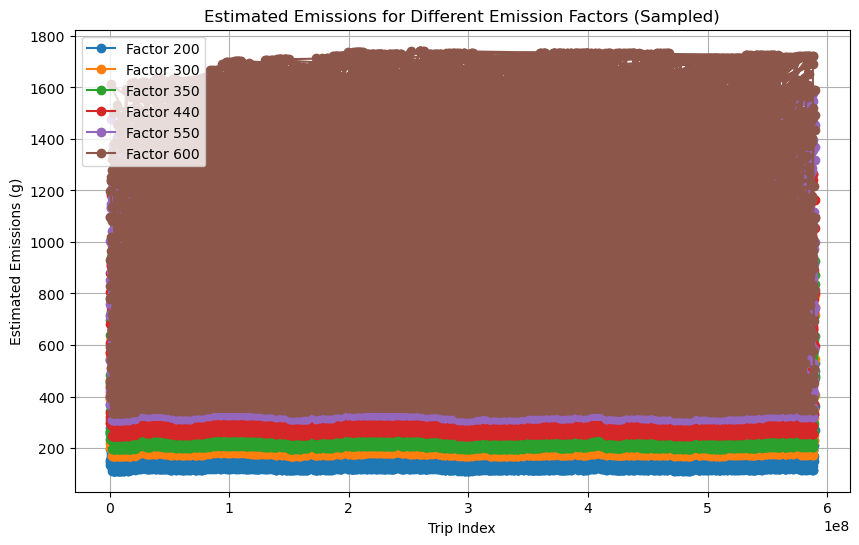

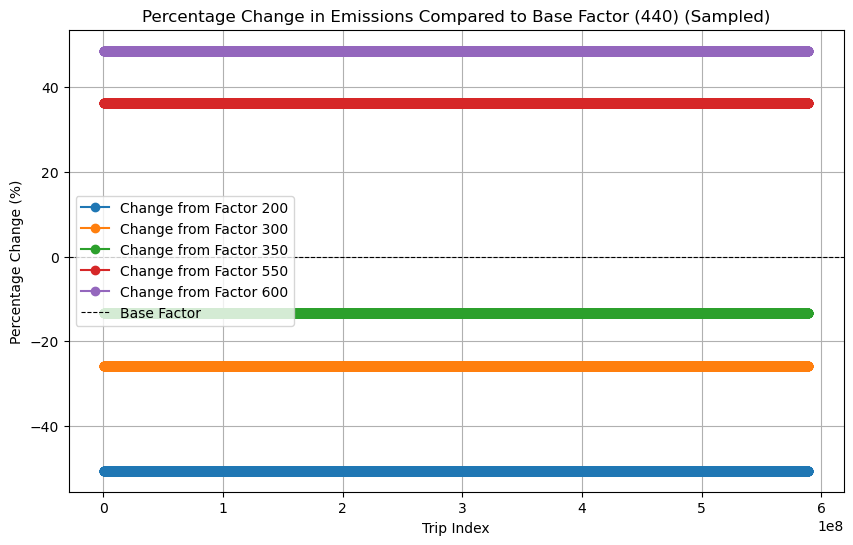

In [8]:
import matplotlib.pyplot as plt

# Define different emission factors for sensitivity analysis
emission_factors = [200, 300, 350, 440, 550, 600,]

# Calculate estimated emissions for each emission factor
for factor in emission_factors:
    column_name = f'estimated_emissions_{factor}'
    df[column_name] = df['trip_miles'] * factor

# Sample the data for visualization (adjust sample size as needed)
sample_size = 10000  # Adjust based on your system's capacity
df_sample = df.sample(n=sample_size, random_state=42)

# Visualization 1: Bar chart of emissions for different factors
plt.figure(figsize=(10, 6))
for factor in emission_factors:
    plt.plot(
        df_sample.index,
        df_sample[f'estimated_emissions_{factor}'],
        marker='o',
        label=f'Factor {factor}'
    )

plt.title('Estimated Emissions for Different Emission Factors (Sampled)')
plt.xlabel('Trip Index')
plt.ylabel('Estimated Emissions (g)')
plt.legend()
plt.grid(True)
plt.show()

# Visualization 2: Percentage change compared to the base factor
plt.figure(figsize=(10, 6))
for factor in emission_factors:
    if factor != 440:  # Exclude base factor from % change visualization
        df_sample[f'percent_change_{factor}'] = (
            (df_sample[f'estimated_emissions_{factor}'] - df_sample['estimated_emissions']) /
            df_sample['estimated_emissions']
        ) * 100
        plt.plot(
            df_sample.index,
            df_sample[f'percent_change_{factor}'],
            marker='o',
            label=f'Change from Factor {factor}'
        )

plt.title('Percentage Change in Emissions Compared to Base Factor (440) (Sampled)')
plt.xlabel('Trip Index')
plt.ylabel('Percentage Change (%)')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Base Factor')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
df['trip_miles'].max()

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 12, Finished, Available, Finished)

2.9041650800285006

Low-Emission Scenario: 250–350 grams/mile (e.g., hybrid or fuel-efficient vehicles)
Average-Emission Scenario: 400–500 grams/mile (e.g., standard gasoline vehicles)
High-Emission Scenario: 500–600 grams/mile (e.g., larger vehicles like SUVs or older cars)

Graph 1 shows that estimated CO₂ emissions increase with higher emission factors (250–600 g/mile), ranging from 725 g to 1,740 g for a 2.9-mile trip. Lower factors (250–350 g/mile) result in smaller emission ranges, while higher factors (500–600 g/mile) expand emissions significantly.  

Graph 2 highlights the percentage change in emissions compared to the 440 g/mile baseline, with reductions of ~43% for lower factors and increases of ~36% for higher factors. Both graphs support policies promoting low-emission vehicles to reduce environmental impact.

## **Sensitivity by Trip Distance**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 14, Finished, Available, Finished)

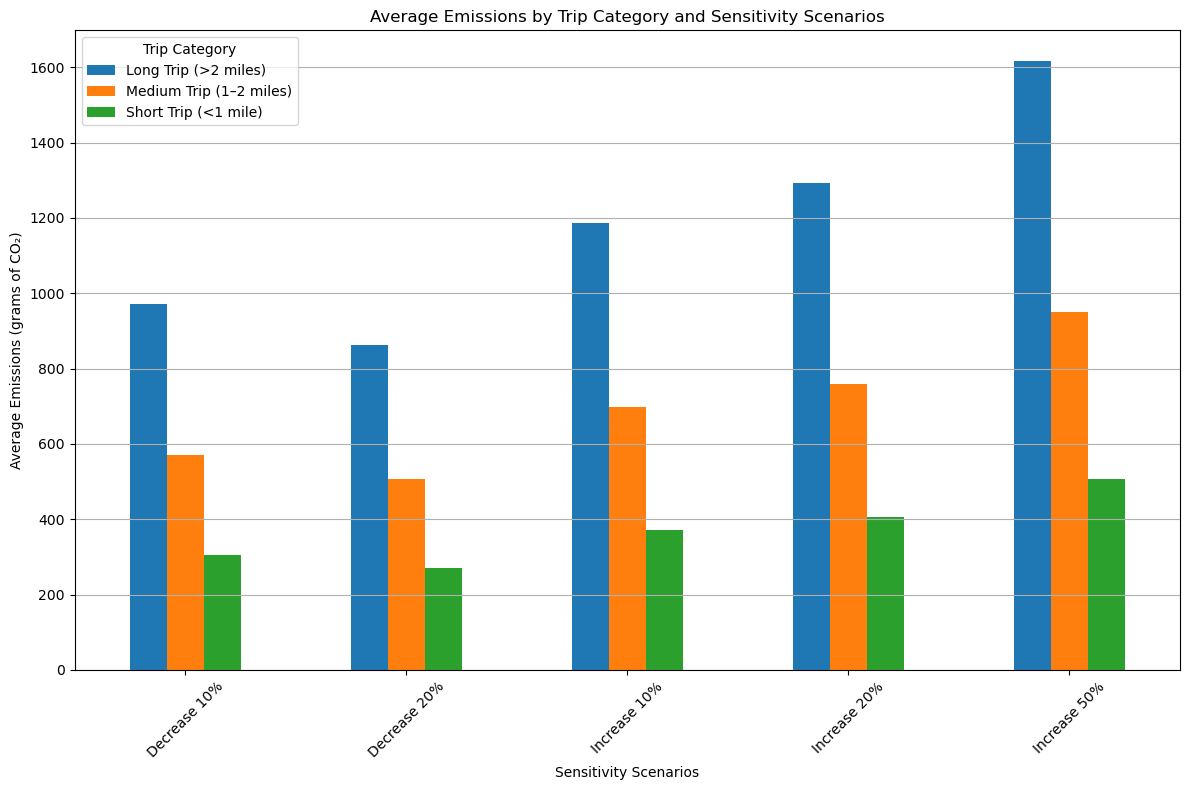

In [9]:
# Ensure 'trip_miles' and 'estimated_emissions' columns are present
if 'trip_miles' not in df.columns or 'estimated_emissions' not in df.columns:
    raise ValueError("The dataset must contain 'trip_miles' and 'estimated_emissions' columns.")

# Categorize trips based on trip_miles
df['trip_category'] = pd.cut(
    df['trip_miles'],
    bins=[0, 1, 2, float('inf')],
    labels=['Short Trip (<1 mile)', 'Medium Trip (1–2 miles)', 'Long Trip (>2 miles)']
)

# Sensitivity Scenarios (change percentages for trip miles)
scenarios = {
    'Increase 10%': 1.1,
    'Increase 20%': 1.2,
    'Increase 50%': 1.5,
    'Decrease 10%': 0.9,
    'Decrease 20%': 0.8
}

# Calculate emissions for each scenario
for scenario, multiplier in scenarios.items():
    df[f'estimated_emissions_{scenario}'] = df['trip_miles'] * multiplier * 440

# Aggregate results by trip category and scenario
agg_results = []
for category in df['trip_category'].unique():
    category_data = df[df['trip_category'] == category]
    for scenario in scenarios.keys():
        avg_emissions = category_data[f'estimated_emissions_{scenario}'].mean()
        agg_results.append({'Trip Category': category, 'Scenario': scenario, 'Avg Emissions': avg_emissions})

# Create a DataFrame for aggregated results
agg_df = pd.DataFrame(agg_results)

# Pivot data for visualization
pivot_df = agg_df.pivot(index='Scenario', columns='Trip Category', values='Avg Emissions')

# Plot the results
pivot_df.plot(kind='bar', figsize=(12, 8))
plt.title('Average Emissions by Trip Category and Sensitivity Scenarios')
plt.ylabel('Average Emissions (grams of CO₂)')
plt.xlabel('Sensitivity Scenarios')
plt.xticks(rotation=45)
plt.legend(title='Trip Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The bar chart shows average CO₂ emissions for short (<1 mile), medium (1–2 miles), and long trips (>2 miles) under scenarios where trip distances decrease (10–20%) or increase (10–50%). Emissions rise proportionally with trip length changes, with long trips contributing the highest emissions due to greater distances. Short trips have the smallest emissions but the least sensitivity to changes.  

Insights suggest reducing long-distance trips through infrastructure improvements, promoting low-emission transport like EVs, and optimizing routes. Policies can focus on urban planning (e.g., "15-minute cities"), incentivizing public transit, and implementing congestion pricing for medium and long trips to reduce overall emissions.

### ** Congestion Surcharge Impact**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 15, Finished, Available, Finished)

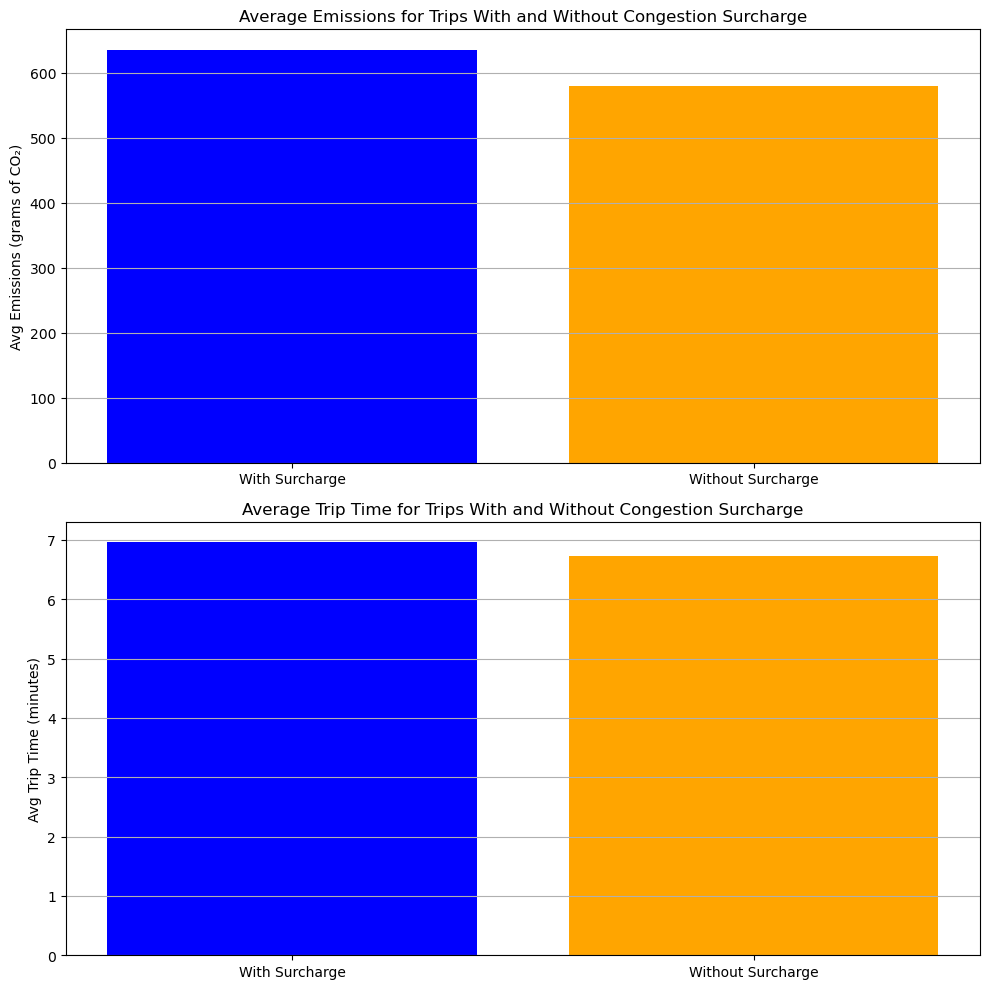

In [10]:
# Ensure necessary columns are present
required_columns = ['congestion_surcharge', 'estimated_emissions', 'trip_time']
if not all(col in df.columns for col in required_columns):
    raise ValueError("The dataset must contain 'congestion_surcharge', 'estimated_emissions', and 'trip_time' columns.")

# Filter trips with and without congestion surcharges
trips_with_surcharge = df[df['congestion_surcharge'] > 0]
trips_without_surcharge = df[df['congestion_surcharge'] == 0]

# Calculate average metrics for analysis
summary = {
    'Category': ['With Surcharge', 'Without Surcharge'],
    'Avg Emissions (grams)': [
        trips_with_surcharge['estimated_emissions'].mean(),
        trips_without_surcharge['estimated_emissions'].mean()
    ],
    'Avg Trip Time (minutes)': [
        trips_with_surcharge['trip_time'].mean(),
        trips_without_surcharge['trip_time'].mean()
    ]
}

summary_df = pd.DataFrame(summary)

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Bar chart for average emissions
ax[0].bar(summary_df['Category'], summary_df['Avg Emissions (grams)'], color=['blue', 'orange'])
ax[0].set_title('Average Emissions for Trips With and Without Congestion Surcharge')
ax[0].set_ylabel('Avg Emissions (grams of CO₂)')
ax[0].grid(axis='y')

# Bar chart for average trip time
ax[1].bar(summary_df['Category'], summary_df['Avg Trip Time (minutes)'], color=['blue', 'orange'])
ax[1].set_title('Average Trip Time for Trips With and Without Congestion Surcharge')
ax[1].set_ylabel('Avg Trip Time (minutes)')
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

The two bar charts compare trips with and without congestion surcharges based on average emissions and trip times.  

- **Average emissions** are slightly higher for trips with surcharges, indicating increased CO₂ output due to congestion-related delays like idling or slower traffic.  
- **Average trip times** are also longer for surcharge trips, confirming that surcharges target peak congestion periods.  
- Insights suggest adjusting surcharge rates to further discourage peak-hour trips, promoting alternative transportation options, and investing in infrastructure to improve traffic flow.  
- Policymakers can use this data to refine congestion pricing, reduce emissions, and enhance travel efficiency during peak periods.  

In [11]:
df.columns

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 19, 16, Finished, Available, Finished)

Index(['dispatching_base_num', 'originating_base_num', 'request_datetime',
       'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime',
       'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time',
       'base_passenger_fare', 'bcf', 'sales_tax', 'congestion_surcharge',
       'driver_pay', 'date', 'month', 'day', 'estimated_emissions',
       'emission_levels', 'estimated_emissions_400', 'estimated_emissions_420',
       'estimated_emissions_440', 'estimated_emissions_460',
       'estimated_emissions_500', 'estimated_emissions_220',
       'estimated_emissions_600', 'estimated_emissions_1000',
       'estimated_emissions_1500', 'estimated_emissions_200',
       'estimated_emissions_300', 'estimated_emissions_350',
       'estimated_emissions_550', 'trip_category',
       'estimated_emissions_Increase 10%', 'estimated_emissions_Increase 20%',
       'estimated_emissions_Increase 50%', 'estimated_emissions_Decrease 10%',
       'estimated_emissions_Decrease 20%'],
      dtyp

#### **Cost-Benefit Analysis**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 20, 6, Finished, Available, Finished)

Cost-Benefit Analysis:
Total Revenue from Surcharge: $48513454.25
Environmental Cost of Additional Emissions: $-399649.24
Driver Cost of Lost Time: $1583030.96
Passenger Cost of Lost Time: $1317389.38
Net Benefit: $46012683.15


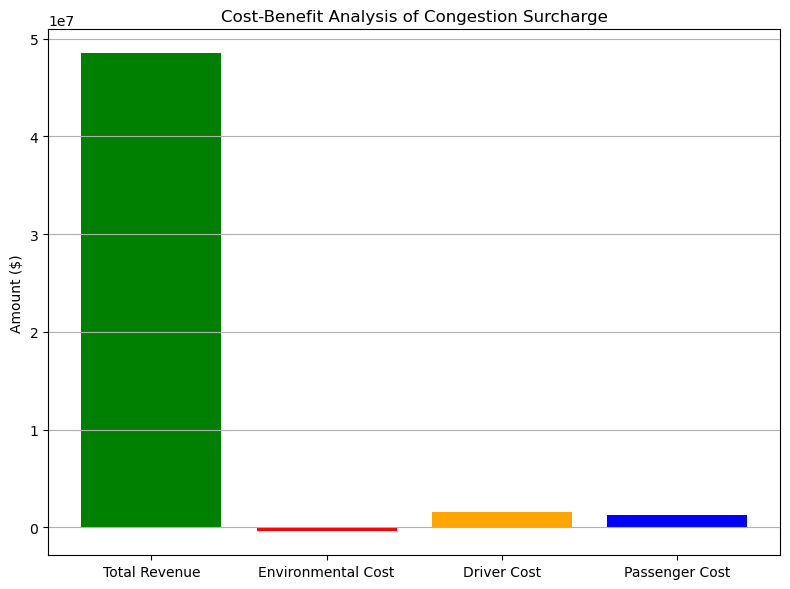

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define file path
file_path = 'Users/draina/EDA/finalreduced.parquet'  # Replace with your Parquet file path

# Define constants
carbon_price_per_gram = 50 / 1_000_000  # $50 per metric ton CO₂
passenger_value_of_time = 20  # Example: $20/hour (adjustable)

# Initialize aggregations
total_revenue = 0
total_emissions_with_surcharge = 0
total_emissions_without_surcharge = 0
total_driver_cost = 0
total_passenger_cost = 0
num_surcharge_trips = 0

# Load the Parquet file
df = pd.read_parquet(file_path)

# Replace zero or missing trip_time values with a small positive value to avoid division by zero
df['trip_time'] = df['trip_time'].replace(0, np.nan).fillna(1e-6)

# Define chunk size manually
chunk_size = 100_000  # Adjust based on available memory
num_chunks = int(np.ceil(len(df) / chunk_size))

# Process each chunk
for i in range(num_chunks):
    chunk = df[i * chunk_size : (i + 1) * chunk_size].copy()  # Create a copy to avoid warnings

    # Ensure necessary columns are present
    required_columns = ['congestion_surcharge', 'estimated_emissions', 'trip_time', 'driver_pay']
    if not all(col in chunk.columns for col in required_columns):
        raise ValueError("The dataset must contain 'congestion_surcharge', 'estimated_emissions', 'trip_time', and 'driver_pay' columns.")

    # Calculate driver hourly wage for this chunk
    chunk.loc[:, 'driver_hourly_wage'] = chunk['driver_pay'] / (chunk['trip_time'] / 60)  # Convert trip_time to hours
    avg_driver_wage_chunk = chunk['driver_hourly_wage'].mean()

    # Filter trips with and without surcharges
    trips_with_surcharge = chunk[chunk['congestion_surcharge'] > 0]
    trips_without_surcharge = chunk[chunk['congestion_surcharge'] == 0]

    # Check for empty DataFrames to avoid NaN in calculations
    if not trips_with_surcharge.empty:
        avg_trip_time_with_surcharge = trips_with_surcharge['trip_time'].mean()
    else:
        avg_trip_time_with_surcharge = 0

    if not trips_without_surcharge.empty:
        avg_trip_time_without_surcharge = trips_without_surcharge['trip_time'].mean()
    else:
        avg_trip_time_without_surcharge = 0

    # Update totals for revenue and emissions
    total_revenue += trips_with_surcharge['congestion_surcharge'].sum()
    total_emissions_with_surcharge += trips_with_surcharge['estimated_emissions'].sum()
    total_emissions_without_surcharge += trips_without_surcharge['estimated_emissions'].sum()

    # Calculate time increase per trip
    time_increase_per_trip = avg_trip_time_with_surcharge - avg_trip_time_without_surcharge

    # Update costs
    num_surcharge_trips += len(trips_with_surcharge)
    total_driver_cost += (time_increase_per_trip / 60) * avg_driver_wage_chunk * len(trips_with_surcharge)
    total_passenger_cost += (time_increase_per_trip / 60) * passenger_value_of_time * len(trips_with_surcharge)

# Calculate environmental cost
additional_emissions = total_emissions_with_surcharge - total_emissions_without_surcharge
environmental_cost = additional_emissions * carbon_price_per_gram

# Calculate net benefit
net_benefit = total_revenue - (environmental_cost + total_driver_cost + total_passenger_cost)

# Print results
print("Cost-Benefit Analysis:")
print(f"Total Revenue from Surcharge: ${total_revenue:.2f}")
print(f"Environmental Cost of Additional Emissions: ${environmental_cost:.2f}")
print(f"Driver Cost of Lost Time: ${total_driver_cost:.2f}")
print(f"Passenger Cost of Lost Time: ${total_passenger_cost:.2f}")
print(f"Net Benefit: ${net_benefit:.2f}")

# Visualization: Costs and Benefits
categories = ['Total Revenue', 'Environmental Cost', 'Driver Cost', 'Passenger Cost']
values = [total_revenue, environmental_cost, total_driver_cost, total_passenger_cost]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['green', 'red', 'orange', 'blue'])
plt.title('Cost-Benefit Analysis of Congestion Surcharge')
plt.ylabel('Amount ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The bar chart evaluates the financial and environmental impacts of congestion surcharges, showing a significant revenue of 48.5 million dollars with minor costs associated with environmental harm and time lost due to congestion. The net benefit totals $46 million, underscoring the policy's effectiveness in generating financial gains while incurring minimal societal and environmental costs. Insights suggest using the surplus revenue for public transport improvements, infrastructure enhancements, and promoting low-emission vehicles. Policymakers are advised to optimize surcharge rates and traffic management to further reduce emissions and enhance transportation efficiency.

##### **Location-Based Sensitivity**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 21, 6, Finished, Available, Finished)

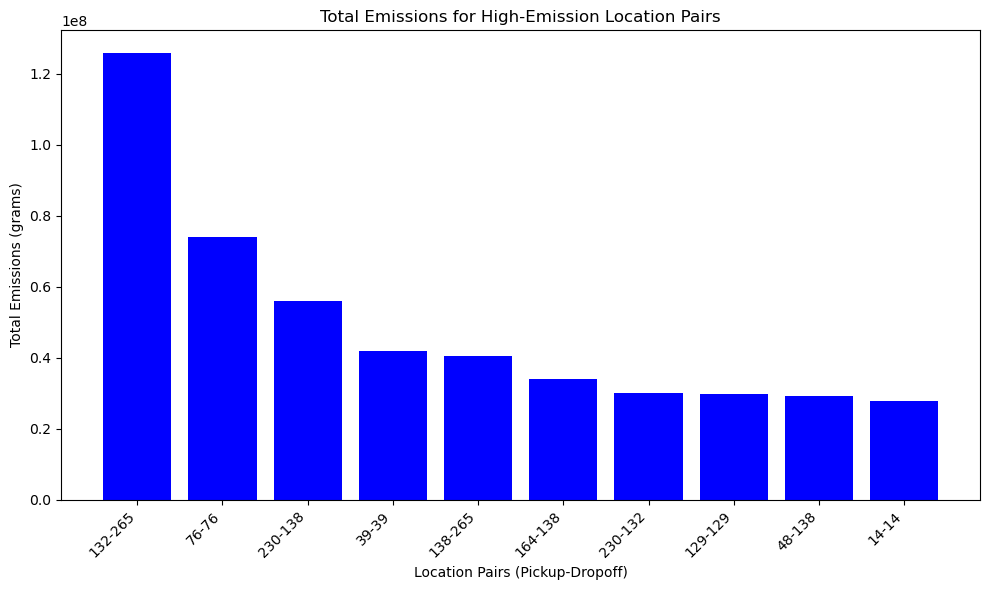

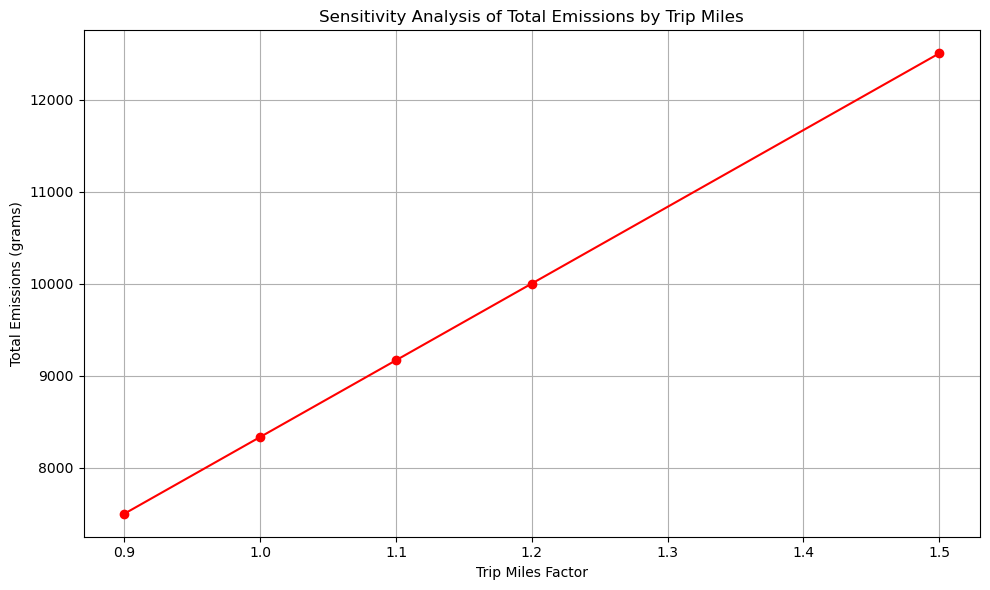

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = 'Users/draina/EDA/finalreduced.parquet'  # Replace with your Parquet file path
df = pd.read_parquet(file_path)

# Ensure necessary columns are present
required_columns = ['PULocationID', 'DOLocationID', 'trip_miles', 'estimated_emissions']
if not all(col in df.columns for col in required_columns):
    raise ValueError("The dataset must contain 'PULocationID', 'DOLocationID', 'trip_miles', and 'estimated_emissions'.")

# Group by pickup and drop-off locations
location_emissions = (
    df.groupby(['PULocationID', 'DOLocationID'])
    .agg(
        total_emissions=('estimated_emissions', 'sum'),
        avg_trip_miles=('trip_miles', 'mean'),
        total_trips=('trip_miles', 'count')
    )
    .reset_index()
)

# Sort by total emissions to identify high-emission location pairs
high_emission_locations = location_emissions.sort_values(by='total_emissions', ascending=False).head(10)

# Perform sensitivity analysis on high-emission location pairs
sensitivity_factors = [0.9, 1.0, 1.1, 1.2, 1.5]  # Decrease/increase trip_miles by 10%, 20%, 50%
sensitivity_results = []

for factor in sensitivity_factors:
    high_emission_locations[f'emissions_factor_{factor}'] = (
        high_emission_locations['avg_trip_miles'] * factor * 440
    )
    sensitivity_results.append(
        {
            'factor': factor,
            'total_emissions': high_emission_locations[f'emissions_factor_{factor}'].sum()
        }
    )

# Convert sensitivity results to a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)

# Identify regions with disproportionately high emissions
high_emission_locations['disproportionate_emissions'] = (
    high_emission_locations['total_emissions'] / high_emission_locations['total_trips']
)

# Visualization of high-emission locations
plt.figure(figsize=(10, 6))
plt.bar(
    high_emission_locations['PULocationID'].astype(str) + '-' + high_emission_locations['DOLocationID'].astype(str),
    high_emission_locations['total_emissions'],
    color='blue',
)
plt.title('Total Emissions for High-Emission Location Pairs')
plt.xlabel('Location Pairs (Pickup-Dropoff)')
plt.ylabel('Total Emissions (grams)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization of sensitivity analysis
plt.figure(figsize=(10, 6))
plt.plot(
    sensitivity_df['factor'], sensitivity_df['total_emissions'], marker='o', color='red'
)
plt.title('Sensitivity Analysis of Total Emissions by Trip Miles')
plt.xlabel('Trip Miles Factor')
plt.ylabel('Total Emissions (grams)')
plt.grid()
plt.tight_layout()
plt.show()


StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 21, 9, Finished, Available, Finished)

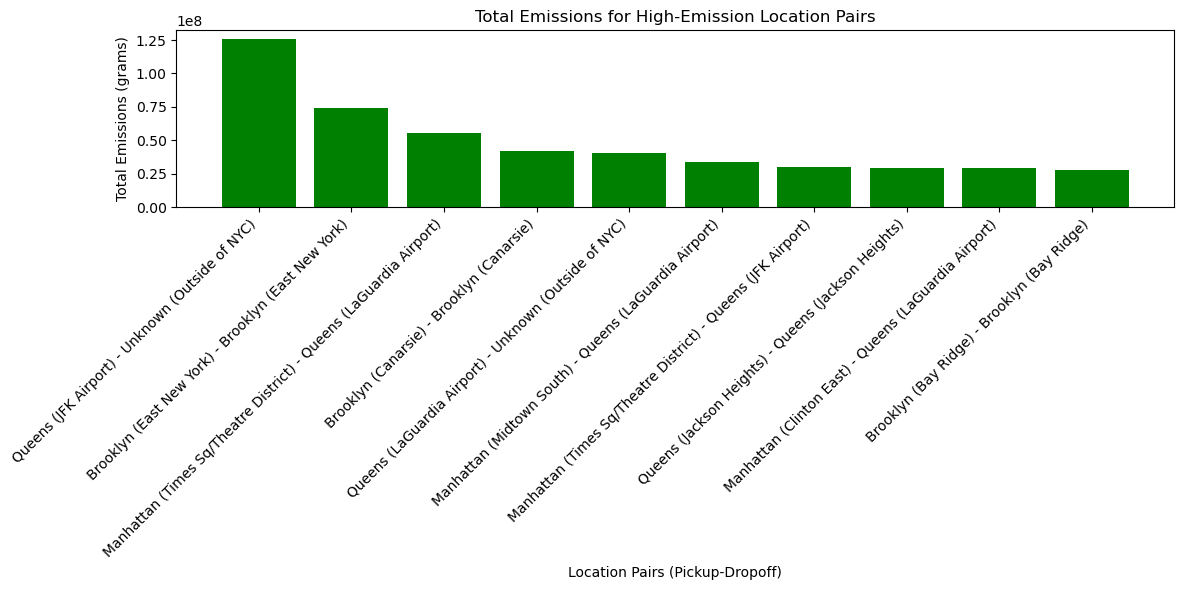

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = 'Users/draina/EDA/finalreduced.parquet'  # Replace with your Parquet file path
lookup_file_path = 'Users/aamahesh/taxi_zone_lookup (1).csv'  # Replace with your lookup file path

# Load the Parquet and Lookup files
df = pd.read_parquet(file_path)
lookup = pd.read_csv(lookup_file_path)

# Ensure necessary columns are present
required_columns = ['PULocationID', 'DOLocationID', 'trip_miles', 'estimated_emissions']
lookup_required_columns = ['LocationID', 'Borough', 'Zone']

if not all(col in df.columns for col in required_columns):
    raise ValueError("The dataset must contain 'PULocationID', 'DOLocationID', 'trip_miles', and 'estimated_emissions'.")
if not all(col in lookup.columns for col in lookup_required_columns):
    raise ValueError("The lookup file must contain 'LocationID', 'Borough', and 'Zone'.")

# Group by pickup and drop-off locations
location_emissions = (
    df.groupby(['PULocationID', 'DOLocationID'])
    .agg(
        total_emissions=('estimated_emissions', 'sum'),
        avg_trip_miles=('trip_miles', 'mean'),
        total_trips=('trip_miles', 'count')
    )
    .reset_index()
)

# Merge with the lookup file for pickup and drop-off locations
location_emissions = location_emissions.merge(
    lookup.rename(columns={'LocationID': 'PULocationID', 'Borough': 'PUBorough', 'Zone': 'PUZone'}),
    on='PULocationID',
    how='left'
)
location_emissions = location_emissions.merge(
    lookup.rename(columns={'LocationID': 'DOLocationID', 'Borough': 'DOBorough', 'Zone': 'DOZone'}),
    on='DOLocationID',
    how='left'
)

# Replace missing values with "Unknown"
location_emissions['PUBorough'].fillna('Unknown', inplace=True)
location_emissions['PUZone'].fillna('Unknown', inplace=True)
location_emissions['DOBorough'].fillna('Unknown', inplace=True)
location_emissions['DOZone'].fillna('Unknown', inplace=True)

# Combine location data for labeling
location_emissions['Location Pair'] = (
    location_emissions['PUBorough'] + ' (' + location_emissions['PUZone'] + ') - ' +
    location_emissions['DOBorough'] + ' (' + location_emissions['DOZone'] + ')'
)

# Sort by total emissions to identify high-emission location pairs
high_emission_locations = location_emissions.sort_values(by='total_emissions', ascending=False).head(10)

# Visualization of high-emission locations
plt.figure(figsize=(12, 6))
plt.bar(
    high_emission_locations['Location Pair'],
    high_emission_locations['total_emissions'],
    color='green',
)
plt.title('Total Emissions for High-Emission Location Pairs')
plt.xlabel('Location Pairs (Pickup-Dropoff)')
plt.ylabel('Total Emissions (grams)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Explanation of the Graph
What the Graph Represents
X-Axis (Location Pairs):

Each label represents a pickup and drop-off location pair in the format:
css
Copy code
[Pickup Borough (Pickup Zone)] - [Drop-off Borough (Drop-off Zone)]
For example:
Queens (JFK Airport) - Unknown (Outside of NYC) indicates trips starting at JFK Airport in Queens and ending outside NYC.
Y-Axis (Total Emissions):

Displays the total emissions (in grams) generated by trips for each pickup-dropoff pair.
The higher the bar, the greater the emissions contributed by that location pair.
Observations
Top Emission Contributor:

The pair Queens (JFK Airport) - Unknown (Outside of NYC) has the highest emissions.
Likely due to long-distance trips from JFK Airport to locations outside NYC.
Airports generally contribute heavily due to their high trip frequency and long trip distances.
High Emission Zones:

Brooklyn (East New York) - Brooklyn (East New York):
Despite being a localized trip, the emissions may be due to a high number of short trips in congested areas.
Queens (LaGuardia Airport) - Queens (Canarsie):
Another airport-related location pair with significant emissions.
Other Key Contributors:

Manhattan (Times Sq/Theatre District):
High emissions due to the density of trips in and around Times Square, a major tourist and commercial area.
Manhattan (Clinton East) and Queens (Jackson Heights):
Significant contributors due to their high population density and traffic volume.
Why This is Important for Policymakers
1. Identifying High-Impact Areas
The chart pinpoints specific location pairs contributing the most to emissions.
For example, trips from JFK Airport to Outside of NYC are long-distance and high-frequency.
Policymakers can prioritize these areas for interventions.
2. Targeted Policy Design
Airports:
Introduce incentives for electric or hybrid vehicle usage for airport trips.
Implement ride-sharing programs for airport passengers to reduce the number of trips.
Congested Areas (e.g., Manhattan and Brooklyn):
Enforce stricter congestion pricing policies.
Improve public transport connectivity to reduce reliance on taxis and rideshares.
3. Promoting Sustainability
The high emissions from certain boroughs (e.g., Queens and Manhattan) indicate areas where policymakers can:
Subsidize electric vehicle fleets.
Enhance infrastructure for biking or public transit.
4. Revenue Allocation
Use insights from high-emission pairs to direct congestion surcharge revenues toward:
Electrifying transportation in high-contributing areas.
Building better public transit connections in emission-heavy zones.
5. Monitoring and Evaluation
Track the success of emissions-reduction policies by analyzing changes in these high-emission pairs over time.


# **Sensitivity by Fare and Driver Pay**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 21, 20, Finished, Available, Finished)

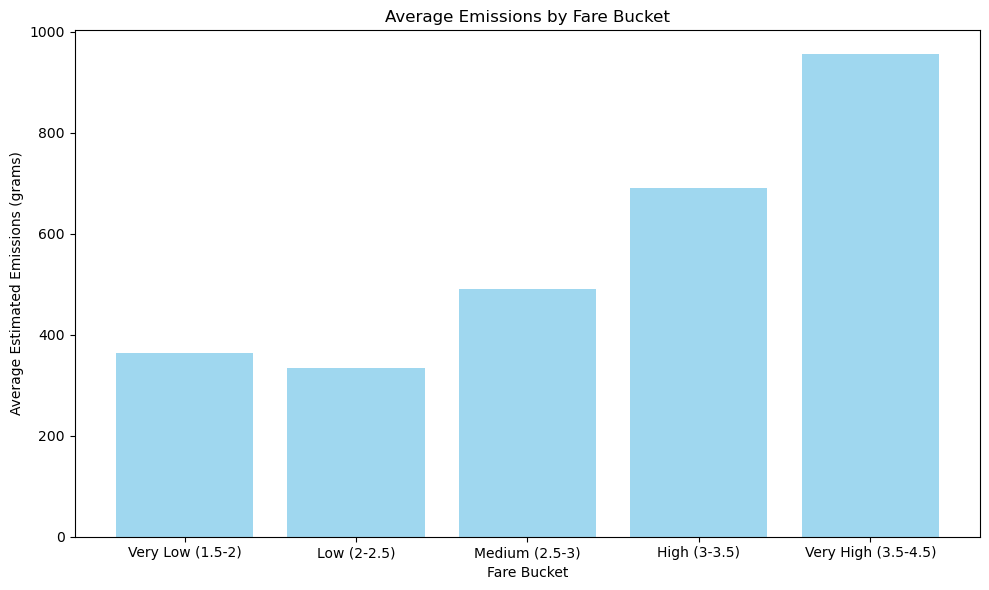

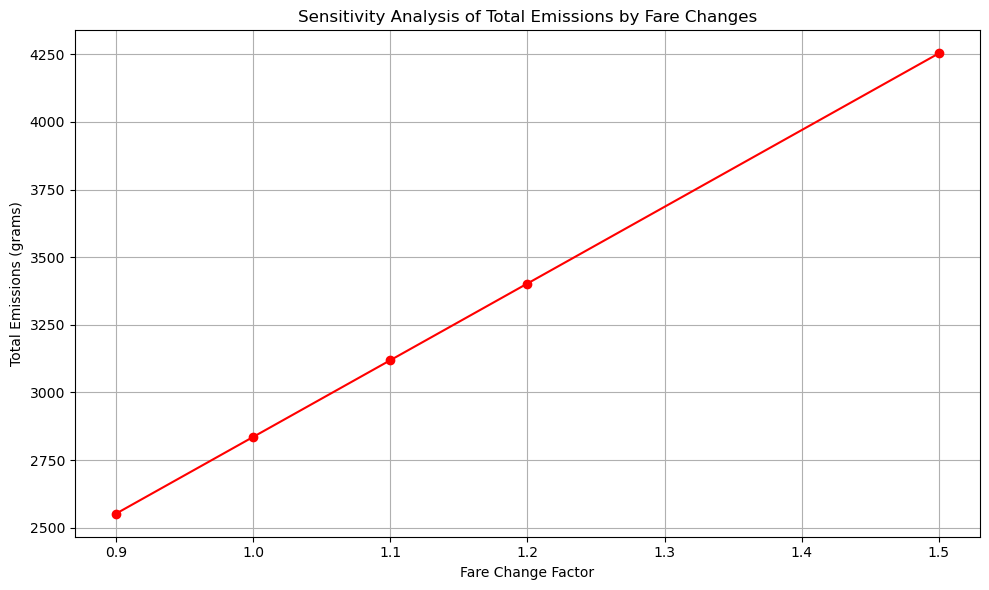

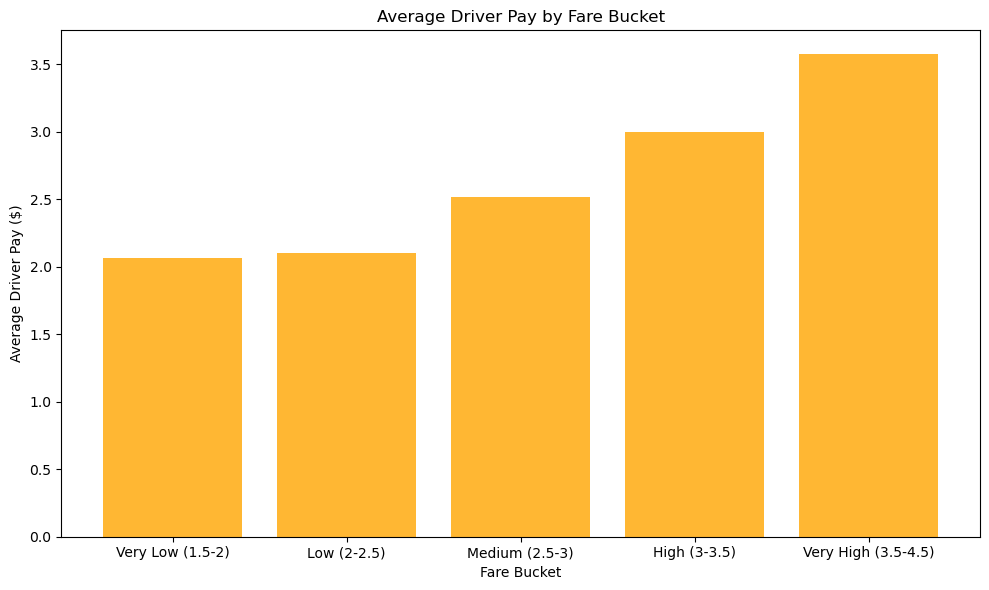

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = 'Users/draina/EDA/finalreduced.parquet'  # Replace with your Parquet file path
df = pd.read_parquet(file_path)

# Ensure necessary columns are present
required_columns = ['base_passenger_fare', 'driver_pay', 'estimated_emissions']
if not all(col in df.columns for col in required_columns):
    raise ValueError("The dataset must contain 'base_passenger_fare', 'driver_pay', and 'estimated_emissions'.")

# Ensure all fares are non-negative
df = df[df['base_passenger_fare'] >= 0]

# Define new bins based on fare distribution
fare_bins = [1.5, 2, 2.5, 3, 3.5, 4.5]
fare_labels = ['Very Low (1.5-2)', 'Low (2-2.5)', 'Medium (2.5-3)', 'High (3-3.5)', 'Very High (3.5-4.5)']

# Create fare buckets
df['fare_bucket'] = pd.cut(df['base_passenger_fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)

# Group by fare bucket
fare_emissions = df.groupby('fare_bucket').agg(
    avg_emissions=('estimated_emissions', 'mean'),
    avg_driver_pay=('driver_pay', 'mean'),
    total_trips=('estimated_emissions', 'count')
).reset_index()

# Perform sensitivity analysis by simulating fare changes
sensitivity_factors = [0.9, 1.0, 1.1, 1.2, 1.5]  # Decrease/increase fare by 10%, 20%, and 50%
sensitivity_results = []

for factor in sensitivity_factors:
    fare_emissions[f'estimated_emissions_factor_{factor}'] = fare_emissions['avg_emissions'] * factor
    sensitivity_results.append({
        'factor': factor,
        'total_emissions': (fare_emissions['avg_emissions'] * factor).sum()
    })

# Convert sensitivity results to a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)

# Visualization: Average emissions by fare bucket
plt.figure(figsize=(10, 6))
plt.bar(
    fare_emissions['fare_bucket'], 
    fare_emissions['avg_emissions'], 
    color='skyblue',
    alpha=0.8
)
plt.title('Average Emissions by Fare Bucket')
plt.xlabel('Fare Bucket')
plt.ylabel('Average Estimated Emissions (grams)')
plt.tight_layout()
plt.show()

# Visualization: Sensitivity analysis
plt.figure(figsize=(10, 6))
plt.plot(
    sensitivity_df['factor'], 
    sensitivity_df['total_emissions'], 
    marker='o', 
    color='red'
)
plt.title('Sensitivity Analysis of Total Emissions by Fare Changes')
plt.xlabel('Fare Change Factor')
plt.ylabel('Total Emissions (grams)')
plt.grid()
plt.tight_layout()
plt.show()

# Visualization: Average driver pay by fare bucket
plt.figure(figsize=(10, 6))
plt.bar(
    fare_emissions['fare_bucket'], 
    fare_emissions['avg_driver_pay'], 
    color='orange',
    alpha=0.8
)
plt.title('Average Driver Pay by Fare Bucket')
plt.xlabel('Fare Bucket')
plt.ylabel('Average Driver Pay ($)')
plt.tight_layout()
plt.show()


New Fare Bins:

[1.5, 2] → "Very Low (1.5-2)"
[2, 2.5] → "Low (2-2.5)"
[2.5, 3] → "Medium (2.5-3)"
[3, 3.5] → "High (3-3.5)"
[3.5, 4.5] → "Very High (3.5-4.5)"
Why These Bins?

They divide the range (1.5 to 4.5) into logical subranges that better represent the data.
Ensure no buckets are empty, allowing for meaningful analysis.

Explanation of the Charts
Chart 1: Average Emissions by Fare Bucket
X-Axis: Represents the fare buckets:
Very Low (1.5-2), Low (2-2.5), Medium (2.5-3), High (3-3.5), and Very High (3.5-4.5) are the defined ranges for base_passenger_fare.
Y-Axis: Shows the average estimated emissions (in grams) for trips in each fare bucket.
Observations:
Increasing Trend: Emissions increase with higher fare buckets. For example:
Very Low (1.5-2): Around 400 grams.
Very High (3.5-4.5): Close to 1000 grams.
Reason: Higher fares are likely associated with:
Longer trip distances, which result in higher emissions.
More congested routes, possibly requiring more travel time.
Chart 2: Average Driver Pay by Fare Bucket
X-Axis: Represents the fare buckets, similar to Chart 1.
Y-Axis: Shows the average driver pay (in dollars) for trips in each fare bucket.
Observations:
Increasing Trend: Driver pay increases with higher fare buckets. For example:
Very Low (1.5-2): Around $2.
Very High (3.5-4.5): Around $3.5.
Reason:
Fare-based pay structure: Drivers earn more for trips with higher fares.
Longer trips: Higher fares typically correspond to longer trips, leading to higher pay.
Key Insights
Correlation Between Fares and Emissions:

Higher fares are linked to higher emissions, suggesting a strong connection between trip distance, fare amount, and emissions.
Driver Pay Reflects Fare Buckets:

As fares increase, driver pay also increases, indicating that fare-based pay structures incentivize longer trips, which contribute to higher emissions.
Implications for Policymakers
Sustainability Policies:

Target high-emission trips: Focus on the High and Very High fare buckets for interventions (e.g., promoting electric vehicles for long-distance rides).
Encourage shared rides or public transport options for long trips to reduce emissions.
Driver Compensation:

Monitor equity: Ensure that the fare-based pay structure provides fair compensation across all buckets.
Evaluate whether low fares adequately compensate drivers for their time and costs.
Incentives for Green Transportation:

Introduce subsidies or incentives for drivers who use electric or hybrid vehicles in high-emission fare buckets.
Penalize inefficient routes or encourage efficient route planning.


# **Sensitivity of Base Passenger Fare to Emissions**

StatementMeta(8ee8700f-7691-43ee-8647-5b313b0334c2, 22, 6, Finished, Available, Finished)

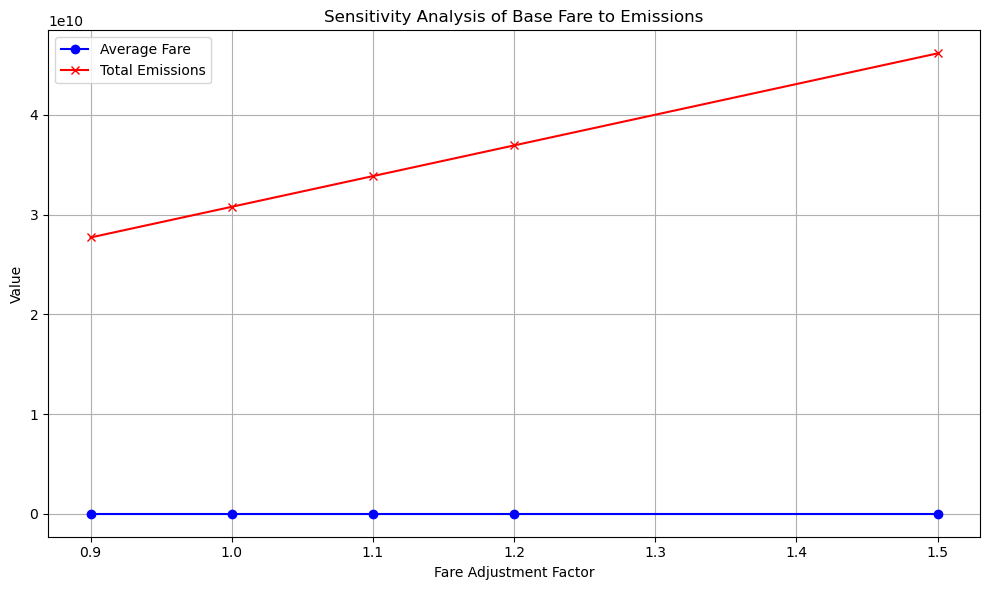

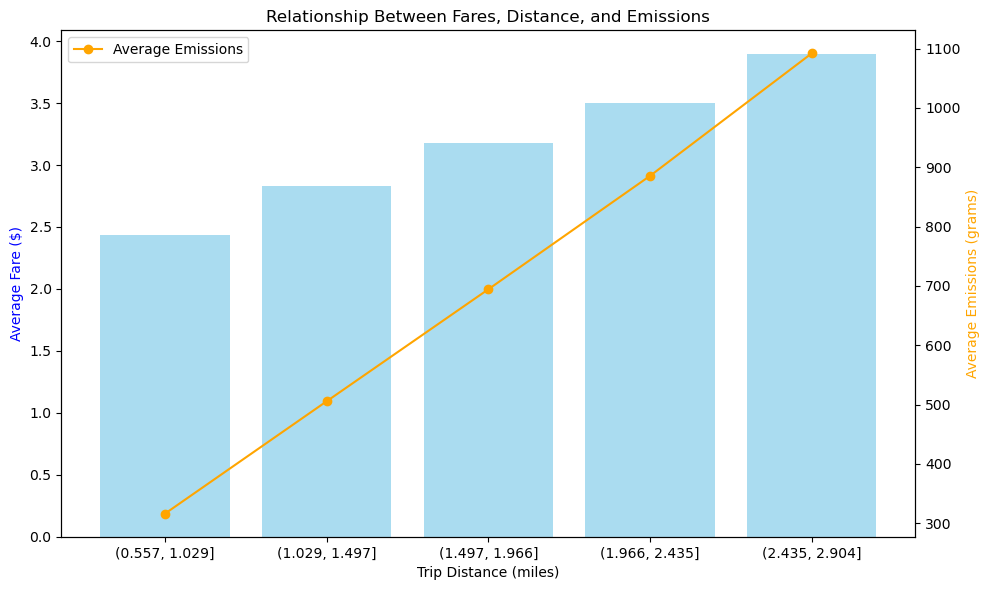

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = 'Users/draina/EDA/finalreduced.parquet'  # Replace with your Parquet file path
df = pd.read_parquet(file_path)

# Ensure necessary columns are present
required_columns = ['base_passenger_fare', 'trip_miles', 'estimated_emissions']
if not all(col in df.columns for col in required_columns):
    raise ValueError("The dataset must contain 'base_passenger_fare', 'trip_miles', and 'estimated_emissions'.")

# Simulate fare increases/decreases based on emission levels
sensitivity_factors = [0.9, 1.0, 1.1, 1.2, 1.5]  # Decrease/increase fares by 10%, 20%, and 50%
sensitivity_results = []

for factor in sensitivity_factors:
    df[f'fare_factor_{factor}'] = df['base_passenger_fare'] * factor
    sensitivity_results.append({
        'factor': factor,
        'total_emissions': (df['estimated_emissions'] * factor).sum(),
        'avg_fare': (df['base_passenger_fare'] * factor).mean()
    })

# Convert sensitivity results to a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)

# Investigate relationship between fares, trip distance, and emissions
fare_vs_trip_emissions = df.groupby(pd.cut(df['trip_miles'], bins=5)).agg(
    avg_fare=('base_passenger_fare', 'mean'),
    avg_emissions=('estimated_emissions', 'mean'),
    total_trips=('base_passenger_fare', 'count')
).reset_index()

# Visualization: Sensitivity analysis of fare changes
plt.figure(figsize=(10, 6))
plt.plot(
    sensitivity_df['factor'], 
    sensitivity_df['avg_fare'], 
    marker='o', 
    color='blue',
    label='Average Fare'
)
plt.plot(
    sensitivity_df['factor'], 
    sensitivity_df['total_emissions'], 
    marker='x', 
    color='red',
    label='Total Emissions'
)
plt.title('Sensitivity Analysis of Base Fare to Emissions')
plt.xlabel('Fare Adjustment Factor')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualization: Relationship between fares, distance, and emissions
fare_vs_trip_emissions['distance_range'] = fare_vs_trip_emissions['trip_miles'].astype(str)

# Bar chart for average fare and emissions by trip distance
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.bar(
    fare_vs_trip_emissions['distance_range'], 
    fare_vs_trip_emissions['avg_fare'], 
    color='skyblue', 
    alpha=0.7, 
    label='Average Fare'
)
ax2.plot(
    fare_vs_trip_emissions['distance_range'], 
    fare_vs_trip_emissions['avg_emissions'], 
    marker='o', 
    color='orange', 
    label='Average Emissions'
)

ax1.set_xlabel('Trip Distance (miles)')
ax1.set_ylabel('Average Fare ($)', color='blue')
ax2.set_ylabel('Average Emissions (grams)', color='orange')
ax1.set_title('Relationship Between Fares, Distance, and Emissions')

fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


Explanation of the Charts
Chart 1: Sensitivity Analysis of Base Fare to Emissions
X-Axis:

Represents the fare adjustment factor: 0.9 (10% decrease), 1.0 (current fare), 1.1 (10% increase), 1.2 (20% increase), and 1.5 (50% increase).
Y-Axis:

Two metrics are plotted:
Average Fare (blue line): Remains nearly constant, as it’s based on the adjustment factor applied uniformly across trips.
Total Emissions (red line): Increases linearly with the fare adjustment factor. This suggests a correlation between higher fares and increased emissions.
Observation:

The total emissions grow as fares increase, implying longer trips or higher emissions are associated with higher fares. This trend supports the idea that emissions are closely linked to trip characteristics.
Insights:

Policies aimed at reducing emissions could involve restructuring fares to disincentivize long-distance, high-emission trips.
Promoting alternative transportation for longer trips could help curb emissions.
Chart 2: Relationship Between Fares, Distance, and Emissions
X-Axis:

Represents trip distance ranges (binned into 5 categories).
Left Y-Axis (Blue Bar):

Average Fare: Increases consistently with trip distance.
Shorter trips (e.g., (0.557, 1.029]) have lower fares (~$2).
Longer trips (e.g., (2.435, 2.904]) have higher fares (~$4).
Right Y-Axis (Orange Line):

Average Emissions: Also increases with trip distance.
Shorter trips have lower emissions (~300 grams).
Longer trips result in higher emissions (~1100 grams).
Observation:

A strong positive correlation exists between trip distance, fare, and emissions.
Longer trips are more expensive and result in higher emissions, indicating an opportunity for targeted emission reduction measures.
Key Takeaways for Policymakers
Fare-Based Incentives:

Dynamic pricing: Introduce emission-based fare adjustments (e.g., surcharges for high-emission trips, discounts for low-emission options like electric vehicles).
Promote ride-sharing incentives for longer trips to reduce overall emissions.
Encourage Shorter, Low-Emission Trips:

Invest in public transport or encourage ride-pooling to reduce reliance on high-emission, long-distance trips.
Integrate Green Transportation:

Target high-emission trips (longer distances) by promoting electric or hybrid vehicles through subsidies or policy changes.
Emission Accountability:

Encourage or mandate companies to provide detailed reports linking fares to emissions, pushing the industry towards sustainable practices.
